# Cryptocurrencies Price Prediction using a RNN

## Abstract
An investment in bitcoin is the equivalent of betting on the increased adoption of this asset. Contrary to the US dollar, which used to be backed by gold and currently is backed by trust on the US government) bitcoin itself has no intrinsic value. This means that bitcoin’s market price is based on the law of supply and demand. Furthermore, bitcoin has a cap on the amount of coins produced, namely 21 million. This makes bitcoin a deflationary asset, which translates into a greater economic value as its supply decreases.
This project uses machine learning to test if bitcoin’s market price can be significantly predicted by other Bitcoin’s blockchain features such as market price, hash rate, difficulty adjustment, transactions volume… A RNN (Recurrent Neural Network) will be used to predict a time-series dataset.

## Goal
- Use a RNN to predict against a time-series dataset of 4 cryptocurrencies: BTC, LTC, ETH, BCH
- The goal is that the neural network doesn't just memorize our data and that it instead "generalizes" and learns the actual problem and patterns associated with it.



## Input data
- The data we'll be using is Open, High, Low, Close, Volume data for Bitcoin, Ethereum, Litecoin and Bitcoin Cash.
- Since there are different ways to measure the price (opening price, closing price, high price, low price...) we specify that the model uses the `Close` and `Volume` columns from the input dataset
- We're going to be tracking the `Close` and `Volume` every minute for Bitcoin, Litecoin, Ethereum, and Bitcoin Cash.

### Install Libraries

In [1]:
!pip install sklearn tensorflow keras pandas numpy matplotlib; 

You should consider upgrading via the '/Users/alvaroserranorivas/.pyenv/versions/3.9.2/envs/bitcoin_linear_regression/bin/python3.9 -m pip install --upgrade pip' command.


### Import Libraries

In [4]:
# import libraries
import random
from collections import deque
from pathlib import Path
import time


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing

# Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

### Define constant variables

##### Key concepts:
- **Neural Network**: ![A basic neural network](https://nickmccullum.com/images/python-deep-learning/intuition-recurrent-neural-networks/basic-neural-network.png)
- **Batches**: Total number of training samples that are fed one-by-one to the Neural Network
- **Epoch**: One epoch is when the dataset has been passed forward and backward the RNN once. Therefore, the greater the number of epochs, the better the accuracy of the model. However, too many epochs could lead to overfitting
- **Overfitting**: The model memorizes its behavior and therefore, it will perform on the training data but it will do poorly on the test or validation data.

##### How to build a RNN from a Feed-Forward Neural Network
1. Squash layers together: ![A squashed neural network](https://nickmccullum.com/images/python-deep-learning/intuition-recurrent-neural-networks/squashed-neural-network.png)
2. Simplify synapses of the neuron to a single line
3. Rotate by 90 degrees
4. Generate a loop around the hidden layer of the neural network  ![A recurrent neural network](https://nickmccullum.com/images/python-deep-learning/intuition-recurrent-neural-networks/recurrent-neural-network.png)

##### How are RNN different?
The hidden layer used on a specific observation a dataset is not only used to generate output for that observation, but it is also used to train the hidden layer of the next observation.
![Comparison](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.tBUpKzl1F8FU5K_eKBYDHAHaEF%26pid%3DApi&f=1)
##### Why do we need a RNN to solve this buying/selling decision problem?
- It allows us to update the hidden state in a deterministic nonlinear way
	- We send the chose price back to the network as an input
- RNNs hold a distributed hidden state that allows them to store a lot of information about the pat efficiently
- RNNs nonlinear dynamics allow them to update their hidden state in a deterministic way where thre is no need to infer the hidden state.

##### Time complexity
Since the hidden layer of one observation is used to train the hidden layer of the next observation, the gradient descent algortihm is then combined with a backpropagation algorithm. 
Therefore, the cost fnuction of the neural network is calculated for each observation in the dataset

#### LSTM
A basic RNN:
![A basic recurrent neural network](https://nickmccullum.com/images/python-deep-learning/lstms/recurrent-neural-network.png)This neural network has neurons and synapses that transmit the weighted sums of the outputs from one layer as the inputs of the next layer. A backpropagation algorithm will move backwards through this algorithm and update the weights of each neuron in response to he cost function computed at each epoch of its training stage.

LSTM applied to a Deep Learning Problem![An LSTM](https://nickmccullum.com/images/python-deep-learning/lstms/lstm.png)
![The notation we'll be using in our LSTM tutorial](https://nickmccullum.com/images/python-deep-learning/lstms/lstm-notation.png)

##### Appearance of each layer in the LSTM RNN
![A node from an LSTM neural network](https://nickmccullum.com/images/python-deep-learning/lstms/lstm-node.png)

##### Activation function: Sigmoid function
The ![sigmoid function](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.YuabQiGBA-W-5PWsojwN5AHaDe%26pid%3DApi&f=1) is used as a type of activation function in LSTMs that determines what information is passed through a gate to affect the network’s cell state.
- Loss is a calculation of error: 
	- a RNN does not attempt to maximize accuracy
	- a RNN's goal is to minimize loss


In [5]:
PRECEDING_PRICES = 60
FUTURE_PRICES_PREDICT = 3
EPOCHS = 10  # how many times to train the model
BATCH_SIZE = 64  # how many samples per batch
TO_PREDICT = "BTC-USD"
NAME = f"{TO_PREDICT}-{PRECEDING_PRICES}-SEQ-{FUTURE_PRICES_PREDICT}-PRED-{int(time.time())}" 

### The process of building a RNN
#### **Input Data**: Combine price and volume for each coin into a single feature 

In [4]:
main_df = pd.DataFrame() 

data_directory: Path = Path("./crypto-data")

for file in data_directory.glob("*.csv"):
    file_name = file.name.split(".")[0]
    df = pd.read_csv(f"{data_directory.name}/{file.name}", names = ["time", "low", "high", "open", "close", "volume"],  encoding="ISO-8859-1")
    df.rename(columns={"close": f"{file_name}_close", "volume": f"{file_name}_volume"}, inplace=True)
    df.set_index("time", inplace=True)
    df = df[[f"{file_name}_close", f"{file_name}_volume"]]
    df.dropna(inplace=True)
    main_df = df if len(main_df) == 0 else main_df.join(df)

main_df.fillna(method="ffill", inplace=True) 
main_df.dropna(inplace=True)
print(main_df.head())

            ETH-USD_close  ETH-USD_volume  BTC-USD_close  BTC-USD_volume  \
time                                                                       
1528968720      486.01001       26.019083    6487.379883        7.706374   
1528968780      486.00000        8.449400    6479.410156        3.088252   
1528968840      485.75000       26.994646    6479.410156        1.404100   
1528968900      486.00000       77.355759    6479.979980        0.753000   
1528968960      486.00000        7.503300    6480.000000        1.490900   

            BCH-USD_close  BCH-USD_volume  LTC-USD_close  LTC-USD_volume  
time                                                                      
1528968720     870.859985       26.856577      96.660004      314.387024  
1528968780     870.099976        1.124300      96.570000       77.129799  
1528968840     870.789978        1.749862      96.500000        7.216067  
1528968900     870.000000        1.680500      96.389999      524.539978  
1528968960     86

#### Define logic for making a decision (Buy/Sell)
- If the "future" column is higher, we buy.
- Else,we sell

In [5]:
def make_order_decision(current_price, future_price):
	if float(current_price) < float(future_price): 
		return 1 # buy order
	else:
		return 0

#### Speculate future price based on closing prices from the past
##### Choose target:
- Price we are trying to predict
- How far out in the future we are trying to predict


In [6]:
main_df["future_price_to_predict"] = main_df[f"{TO_PREDICT}_close"].shift(-FUTURE_PRICES_PREDICT) # negative to shift columnn up
main_df["order_decision"] = list(map(make_order_decision, main_df[f"{TO_PREDICT}_close"], main_df["future_price_to_predict"]))
main_df.dropna(inplace=True)

### Prediction: 
#### Will price rise or fall? 
#### Should I buy or should I sell?
##### Apply feature scaling to the dataset

There are 2 alternatives:
- Standardization
- Normalization

Since our output is trying to predict whether price will fall or rise for each cryptocurrencies:
1. Take the price of all assets
2. Pick a target and take its future price
3. Choose a time frame step: how many observations should be considered when the RNN makes a prediction about the current observation.
4. Make a decision about the classification function we will be using (how are we going to predict the price):
a) Make it a regression question: using a linear activation with output lyer
b) Use **binary classification** (we pick this one)

##### 1. **Balance** the  buys and sells:  make sure that there are the same number of examples for each cryptocurrency (same number of recorded transactions for each coin)
- a) Feed weights to the model to measure error accordingly
- b) Trim down datasets to make them all have approximately the same number of transactions recorded
- Not balancing could lead to a our model to predict only one coin, whichever is the most common, and memorize it
##### 2. Scale and normalize the data
- The order_decision column is not normalized

#### Data validation, and sequence normalization
1. Split training and test datasets: 
- Since the data is inherently sequential, taking sequeneces that do not come in the future is likely a mistake.
2. Validate the data:
- Sequences that are, for example, 1 minute apart, are likely to be the same, thus indicating an identical Buy or Sell signal. This might cause the model to be overfitted on the test split. In order to remediate this, the validation data is sliced while it is still in order
3. Create random sequences and shuffle them before balancing


In [7]:
def normalize_and_scale_df(df):
	df = df.drop("future_price_to_predict", axis=1)
	for column in df.columns:
		if column != "order_decision":
			df[column] = df[column].pct_change()
			df.dropna(inplace=True)
			df[column] = preprocessing.scale(df[column].values)
	df.dropna(inplace=True)
	predictions_sequence = []
	previous_days_sequence = deque(maxlen=PRECEDING_PRICES)	
	for value in df.values:
		previous_days_sequence.append([i for i in value[:-1]])
		if len(previous_days_sequence) == PRECEDING_PRICES:
			predictions_sequence.append([np.array(previous_days_sequence), value[-1]])
	random.shuffle(predictions_sequence)
	buy_orders = []
	not_buy_orders = []
	for sequence, order_decision in predictions_sequence:
		if order_decision == 1:
			buy_orders.append([sequence, order_decision])
		else:
			not_buy_orders.append([sequence, order_decision])
	random.shuffle(buy_orders)
	random.shuffle(not_buy_orders)
	shorter_sequence = min(len(buy_orders), len(not_buy_orders))
	buy_orders = buy_orders[:shorter_sequence]
	not_buy_orders = not_buy_orders[:shorter_sequence]
	predictions_sequence = buy_orders + not_buy_orders
	random.shuffle(predictions_sequence)
	x_data = []
	y_data = []
	for sequence, order_decision in predictions_sequence:
		x_data.append(sequence) 
		y_data.append(order_decision)
	return np.array(x_data), y_data

In [8]:
sorted_dates = sorted(main_df.index.values)
last_5_percent = sorted(main_df.index.values)[-int(len(sorted_dates) * 0.05)]
test_df = main_df[(main_df.index >= last_5_percent)]
print(f"Shape of test data: {test_df.shape}")
main_df = main_df[(main_df.index < last_5_percent)]
print(f"Shape of training data: {main_df.shape}")
# x_train is a numpy array of sequences
# y_train is a list of buy or not to buy (1 or 0)
x_train, y_train = normalize_and_scale_df(main_df)
x_test, y_test = normalize_and_scale_df(test_df)
print(test_df.head())

print(f"train data: {len(x_train)} test data: {len(x_test)}")
print(f"Train Dont buys: {y_train.count(0)}, buys: {y_train.count(1)}")
print(f"Test Dont buys: {y_test.count(0)}, buys: {y_test.count(1)}")

Shape of test data: (5141, 10)
Shape of training data: (97687, 10)
            ETH-USD_close  ETH-USD_volume  BTC-USD_close  BTC-USD_volume  \
time                                                                       
1534904940     291.140015        6.290395    6705.200195        8.163854   
1534905000     291.570007      489.621918    6700.000000        9.827062   
1534905060     292.299988      173.859314    6700.000000       13.631424   
1534905120     292.399994       77.035606    6702.359863       12.383007   
1534905180     292.600006       89.692940    6711.560059       15.645502   

            BCH-USD_close  BCH-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1534904940     559.989990        5.615524      58.220001      135.698441   
1534905000     558.239990       35.015507      57.930000      864.464905   
1534905060     560.640015       84.553719      58.250000      563.237671   
1534905120     560.2

#### Build and train the model
##### Building the model
1. Initialize a Sequential Model
2. Add the first LSTM layer:
	2.1 Number of neurons to include in the first layer
	2.2 `return_sequences` must be set to True so that we can add more layers to the model.
	2.3 Specify the number of timesteps and predictors to use: `closing price` and `volume`
	2.4 Add a Dropout Reguralization function to keep the same number of neurons while we add 3 more LSTM layers to the model
	2.5 set `return_sequences` to False for the last layer
	2.6 Add the output layer to the RNN as an instance of the Dense class. 

In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

2021-11-16 16:46:25.430608: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Model Compilation Settings: Adam Optimizier
1. Use Adam Optmizer
2. Specify the loss function: we use the mean squared error because we are dealing with a continuous variable

In [10]:
opt = Adam(learning_rate=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

##### Model Checkpoint

In [11]:
model_checkpoint = "RNN_Final-{epoch:02d}-{val_accuracy:.3f}"  
checkpoint = ModelCheckpoint("models/{}.model".format(model_checkpoint, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

##### Traning the model

In [12]:
history = model.fit(
    x_train, np.array(y_train),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, np.array(y_test)),
    callbacks=[tensorboard, checkpoint],
)

Epoch 1/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5472

2021-11-16 16:49:47.925878: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/RNN_Final-01-0.531.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-01-0.531.model/assets


1293/1293 [==============================] - 209s 157ms/step - loss: 0.6930 - accuracy: 0.5472 - val_loss: 0.6893 - val_accuracy: 0.5307
Epoch 2/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.5849

INFO:tensorflow:Assets written to: models/RNN_Final-02-0.575.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-02-0.575.model/assets


1293/1293 [==============================] - 242s 187ms/step - loss: 0.6505 - accuracy: 0.5849 - val_loss: 0.6868 - val_accuracy: 0.5753
Epoch 3/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.5979

INFO:tensorflow:Assets written to: models/RNN_Final-03-0.574.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-03-0.574.model/assets


1293/1293 [==============================] - 241s 186ms/step - loss: 0.6453 - accuracy: 0.5979 - val_loss: 0.6734 - val_accuracy: 0.5743
Epoch 4/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6425 - accuracy: 0.6029

INFO:tensorflow:Assets written to: models/RNN_Final-04-0.573.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-04-0.573.model/assets


1293/1293 [==============================] - 231s 179ms/step - loss: 0.6425 - accuracy: 0.6029 - val_loss: 0.6758 - val_accuracy: 0.5728
Epoch 5/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.6060

INFO:tensorflow:Assets written to: models/RNN_Final-05-0.579.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-05-0.579.model/assets


1293/1293 [==============================] - 215s 166ms/step - loss: 0.6402 - accuracy: 0.6060 - val_loss: 0.6716 - val_accuracy: 0.5791
Epoch 6/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.6114

INFO:tensorflow:Assets written to: models/RNN_Final-06-0.573.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-06-0.573.model/assets


1293/1293 [==============================] - 267s 206ms/step - loss: 0.6383 - accuracy: 0.6114 - val_loss: 0.6787 - val_accuracy: 0.5734
Epoch 7/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6132

INFO:tensorflow:Assets written to: models/RNN_Final-07-0.579.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-07-0.579.model/assets


1293/1293 [==============================] - 197s 152ms/step - loss: 0.6376 - accuracy: 0.6132 - val_loss: 0.6728 - val_accuracy: 0.5791
Epoch 8/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6203

INFO:tensorflow:Assets written to: models/RNN_Final-08-0.572.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-08-0.572.model/assets


1293/1293 [==============================] - 195s 151ms/step - loss: 0.6322 - accuracy: 0.6203 - val_loss: 0.6768 - val_accuracy: 0.5715
Epoch 9/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.6270

INFO:tensorflow:Assets written to: models/RNN_Final-09-0.570.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-09-0.570.model/assets


1293/1293 [==============================] - 196s 152ms/step - loss: 0.6285 - accuracy: 0.6270 - val_loss: 0.6815 - val_accuracy: 0.5702
Epoch 10/10
1293/1293 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.6324

INFO:tensorflow:Assets written to: models/RNN_Final-10-0.553.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-10-0.553.model/assets


1293/1293 [==============================] - 233s 180ms/step - loss: 0.6228 - accuracy: 0.6324 - val_loss: 0.6939 - val_accuracy: 0.5529


#### Save Model Score

In [13]:
model_score = model.evaluate(x_test, np.array(y_test), verbose=0)
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])
model.save("models/{}".format(NAME))

Test loss: 0.6938707232475281
Test accuracy: 0.5528988838195801


INFO:tensorflow:Assets written to: models/BTC-USD-60-SEQ-3-PRED-1637099178/assets


INFO:tensorflow:Assets written to: models/BTC-USD-60-SEQ-3-PRED-1637099178/assets


In [14]:
!tensorboard --logdir=logs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)


#### Tensorboard Dashboard Results
- Red: BCH-USD
- Light Blue: BTC-USD
- Dark Blue: ETH-USD
- Orange: LTC-USD

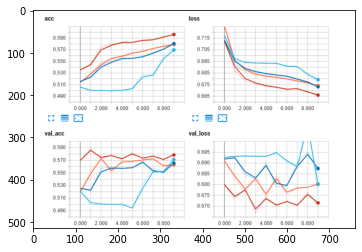

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("tensorboard-dashboard.png")
plt.imshow(image)
plt.show()

#### Conclusion
After we fit the model we notice that, as we train it, the loss goes down and, as a consequence, the accuracy goes up to 98%-99%

#### Bibliography
[1] Machine Learning I Week 14: Sequence Learning Introduction, Alex Graves, Technische Universitaet Muenchen.

[2] CSC2535 2013: Advanced Machine Learning, Lecture 10: Recurrent neural networks, Geoffrey Hinton, University of Toronto.

[3] CS224d Deep NLP, Lecture 8: Recurrent Neural Networks, Richard Socher, Stanford University.

[4] Supervised Sequence Labelling with Recurrent Neural Networks, Alex Graves, Doktors der Naturwissenschaften (Dr. rer. nat.) genehmigten Dissertation.

[5] The Unreasonable Effectiveness of Recurrent Neural Networks, Andrej Karpathy, blog About Hacker's guide to Neural Networks.

[6] Understanding LSTM Networks, Christopher Olah, github blog

[7] Kiros, Ryan, et al. "Skip-thought vectors." Advances in neural information processing systems. 2015.

[8] Dauphin, Yann N., et al. "Language Modeling with Gated Convolutional Networks." arXiv preprint arXiv:1612.08083 (2016).

[9] Gregor, Karol, et al. "DRAW: A recurrent neural network for image generation." arXiv preprint arXiv:1502.04623 (2015).

[10] Chu, Hang, Raquel Urtasun, and Sanja Fidler. "Song From PI: A Musically Plausible Network for Pop Music Generation." arXiv preprint arXiv:1611.03477 (2016).

[11] Zheng, Shuai, et al. "Conditional random fields as recurrent neural networks." Proceedings of the IEEE International Conference on Computer Vision. 2015.

[12] Ramanathan, Vignesh, et al. "Detecting events and key actors in multi-person videos." arXiv preprint arXiv:1511.02917 (2015).

[13] Shah, Rajiv, and Rob Romijnders. "Applying Deep Learning to Basketball Trajectories." arXiv preprint arXiv:1608.03793 (2016).

[14] Baccouche, Moez, et al. "Action classification in soccer videos with long short-term memory recurrent neural networks." International Conference on Artificial Neural Networks. Springer Berlin Heidelberg, 2010.

[15] Chung, Junyoung, et al. "Empirical evaluation of gated recurrent neural networks on sequence modeling." arXiv preprint arXiv:1412.3555 (2014).

[16] Chung, Junyoung, et al. "Gated feedback recurrent neural networks." CoRR, abs/1502.02367 (2015).

[17] Bajpai, P. (2017, November 27). Bitcoin Vs Ethereum: Driven by Different Purposes. Retrieved December 4, 2017, from https://www.investopedia.com/articles/investing/031416/bitcoin-vs-ethereum-driven-different-purposes.asp

[18] Whitbourne, & Clark. (2009, September 08). How much actual money is there in the world? Retrieved December 4, 2017, from https://money.howstuffworks.com/how-much-money-is-in-the-world.htm

[19] IAustralian Bureau of Statistics. (2008, July 25). Time Series Analysis: The Basics. Retrieved November 29, 2012, from Australian Bureau of Statistics: http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics 

[20] Dizikes, P. (2010, March 15). Explained: Regression analysis. Retrieved November 29, 2012, from MITnews: http://web.mit.edu/newsoffice/2010/explained-reg-analysis-0316.html



[21] Gravetter, F. J., & Wallnau, L. B. (2011). Essentials of Statistics for the Behavioral Sciences (7 ed.). Belmont: Wadsworth.